In [28]:
import os
import torch
import logging
import textstat
import subprocess
import bert_score
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from rouge import Rouge
from pathlib import Path
from typing import Optional
from nltk.translate.bleu_score import sentence_bleu

import io_functions

from transformers import PegasusTokenizer, PegasusForConditionalGeneration, TFPegasusForConditionalGeneration
from langchain.text_splitter import RecursiveCharacterTextSplitter
from tqdm.notebook import tqdm

In [29]:
logging.basicConfig(level=logging.INFO, force=True)

In [30]:
if torch.cuda.is_available():
    logging.info(f'GPU Name: {torch.cuda.get_device_name(0)}')
    logging.info(f'CUDA Version: {torch.version.cuda}')
    logging.info(f'GPU Memory Allocated: {torch.cuda.memory_allocated(0) / 1024**3:.2f} GB')
    logging.info(f'GPU Memory Reserved: {torch.cuda.memory_reserved(0) / 1024**3:.2f} GB')

    try:
        logging.info('\nDetailed GPU Info:\n')
        subprocess.run(['nvidia-smi'], check=True)
    except FileNotFoundError:
        logging.info('nvidia-smi not found. Ensure NVIDIA drivers are installed.')
else:
    logging.info('No GPU detected. Running on CPU.')

INFO:root:GPU Name: NVIDIA H100 PCIe
INFO:root:CUDA Version: 12.4
INFO:root:GPU Memory Allocated: 2.15 GB
INFO:root:GPU Memory Reserved: 3.34 GB
INFO:root:
Detailed GPU Info:



Tue Mar 11 16:44:56 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA H100 PCIe               On  | 00000000:21:00.0 Off |                    0 |
| N/A   39C    P0             223W / 310W |   4019MiB / 81559MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [31]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [32]:
company_id = '312932093'
df = io_functions.load_if_scraped(company_id=company_id)

df.info()

INFO:root:successfully loaded local transcripts


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   companyid             2 non-null      int64 
 1   companyname           2 non-null      object
 2   mostimportantdateutc  2 non-null      object
 3   mostimportanttimeutc  2 non-null      object
 4   headline              2 non-null      object
 5   full_text             2 non-null      object
 6   uuid                  2 non-null      object
 7   word_count            2 non-null      int64 
 8   word_count_nltk       2 non-null      int64 
dtypes: int64(3), object(6)
memory usage: 272.0+ bytes


In [33]:
df.head()

,companyid,companyname,mostimportantdateutc,mostimportanttimeutc,headline,full_text,uuid,word_count,word_count_nltk
0,312932093,Google LLC,2018-05-10,15:30:00,Google LLC Presents at The 14th annual Red Hat...,Attendees: Now if there's a company that under...,123c9e75-b8dc-40b1-b21c-ffc9e71e01c6,12407,14475
1,312932093,Google LLC,2023-06-15,21:00:00,"Google LLC, Squarespace, Inc. - M&A Call","Operator: Good afternoon. My name is Sara, and...",123c9e75-b8dc-40b1-b21c-ffc9e71e01c6,10078,11800


In [34]:
df.shape

(2, 9)

In [35]:
model_name = 'human-centered-summarization/financial-summarization-pegasus'

tokenizer = PegasusTokenizer.from_pretrained(model_name)
model = PegasusForConditionalGeneration.from_pretrained(model_name).to(device)

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at human-centered-summarization/financial-summarization-pegasus and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [36]:
max_length = tokenizer.model_max_length
max_length

512

In [37]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=max_length,
    chunk_overlap=max_length/10
)

def summarize_text(text: str):
    
    chunks = text_splitter.split_text(text)
    logging.debug([len(c) for c in chunks])
    
    summaries = []
    for chunk in tqdm(chunks):
        inputs = tokenizer(chunk, return_tensors='pt', truncation=True, max_length=max_length).to(device)
        summary_ids = model.generate(**inputs, max_length=max_length/4, early_stopping=True)
        summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
        summaries.append(summary)
    
    return summaries

In [38]:
def recursive_summary(text, target_length=max_length):
    tokens = tokenizer.tokenize(text)
    logging.debug(f'token size: {len(tokens)}')

    combined_summary = text
    while len(tokens) > target_length:
        summaries = summarize_text(combined_summary)
        combined_summary = ' '.join(summaries)
        tokens = tokenizer.tokenize(combined_summary)


    return combined_summary

In [39]:
summaries = []
for text in tqdm(df.full_text):
    summary = recursive_summary(text=text)
    summaries.append(summary)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/166 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/171 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

In [40]:
summaries[0]

"CEO from Kohl's says the company is excited to work with Red Hat. Machine learning is an approach to making lots of small Scientists at Massachusetts Institute of Technology have developed a machine that can identify cats. Machine learning is at the heart of everything we do. Machine learning takes over the cooking part of the kitchen. Machine learning and big data are changing the way we work. Google has announced partnerships with Canonical and Red Hat. Machine learning and AI are the new programming paradigm. Cloud AutoML lets you adjust what already exists out there. Machine learning is at the heart of everything we do. Machine learning is changing the way we work. Three different chefs are using Google Cloud to run their businesses Ritch talks about why he chose to work with Red Hat. Machine learning is just a way of doing things. Scientists at Massachusetts Institute of Technology have created a program that can identify cats. Machine learning can be used to solve business probl

In [41]:
summary_column = f'{model_name}-summaries'
df[summary_column] = summaries

In [42]:
def evaluate_summary(row, model_name, type = 'baseline'):
    text_to_summarize = row.full_text
    summary = row[summary_column]
    uuid = row.uuid
    company_id = row.companyid
    company_name = row.companyname

    rouge_evaluator = Rouge()
    rouge_scores = rouge_evaluator.get_scores(summary, text_to_summarize)
    
    if isinstance(rouge_scores, list):
        rouge_scores = rouge_scores[0]
    
    reference_tokens = text_to_summarize.split()
    candidate_tokens = summary.split()
    bleu_score = sentence_bleu([reference_tokens], candidate_tokens)
    
    P, R, F1 = bert_score.score(
        [summary], 
        [text_to_summarize], 
        rescale_with_baseline=True, 
        lang='en'
    )
    
    original_len = len(text_to_summarize.split())
    summary_len = len(summary.split())
    compression_ratio = summary_len / original_len if original_len > 0 else 0
    
    readability = textstat.flesch_reading_ease(summary)
    
    results = {}
    results['model_name'] = model_name
    results['uuid'] = uuid
    results['companyid'] = company_id
    results['companyname'] = company_name

    for metric, scores in rouge_scores.items():
        results[f'{metric}_r'] = scores['r']
        results[f'{metric}_p'] = scores['p']
        results[f'{metric}_f'] = scores['f']
    
    results['bleu'] = bleu_score
    results['bert_precision'] = P.item()
    results['bert_recall'] = R.item()
    results['bert_f1'] = F1.item()
    results['compression_ratio'] = compression_ratio
    results['readability'] = readability
    
    return pd.DataFrame([results])

In [43]:
evaluation_results = pd.DataFrame()

for index, row in tqdm(df.iterrows()):
    evaluation_result = evaluate_summary(row, model_name)
    evaluation_results = pd.concat([evaluation_results, evaluation_result], ignore_index=True)

evaluation_results.head()

0it [00:00, ?it/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


,model_name,uuid,companyid,companyname,rouge-1_r,rouge-1_p,rouge-1_f,rouge-2_r,rouge-2_p,rouge-2_f,rouge-l_r,rouge-l_p,rouge-l_f,bleu,bert_precision,bert_recall,bert_f1,compression_ratio,readability
0,human-centered-summarization/financial-summari...,123c9e75-b8dc-40b1-b21c-ffc9e71e01c6,312932093,Google LLC,0.085513,0.758929,0.153707,0.017054,0.283133,0.032170,0.084507,0.750000,0.151899,7.182779e-23,-0.116266,-0.247840,-0.181045,0.019908,58.89
1,human-centered-summarization/financial-summari...,123c9e75-b8dc-40b1-b21c-ffc9e71e01c6,312932093,Google LLC,0.101266,0.674157,0.176082,0.022976,0.337255,0.043022,0.100422,0.668539,0.174615,3.184603e-15,-0.163527,-0.203242,-0.181546,0.030462,57.27


In [44]:
csv_filename = Path('..') / 'data' / 'evaluation_results.csv'

if os.path.exists(csv_filename):
    existing_df = pd.read_csv(csv_filename)
    if ((existing_df.model_name == model_name) & (existing_df.companyid == company_id)).any():
        logging.info(f'model '{model_name}' and {company_id} combination already exists in {csv_filename}. no new row added.')
        updated_df = existing_df
    else:
        updated_df = pd.concat([existing_df, evaluation_results], ignore_index=True)
        logging.info(f'model '{model_name}' not found. appending new row to {csv_filename}.')
else:
    updated_df = evaluation_results
    logging.info(f'{csv_filename} not found. creating new file.')

updated_df.to_csv(csv_filename, index=False)
logging.info(f'results saved to {csv_filename}')

SyntaxError: invalid syntax. Perhaps you forgot a comma? (4078207641.py, line 6)

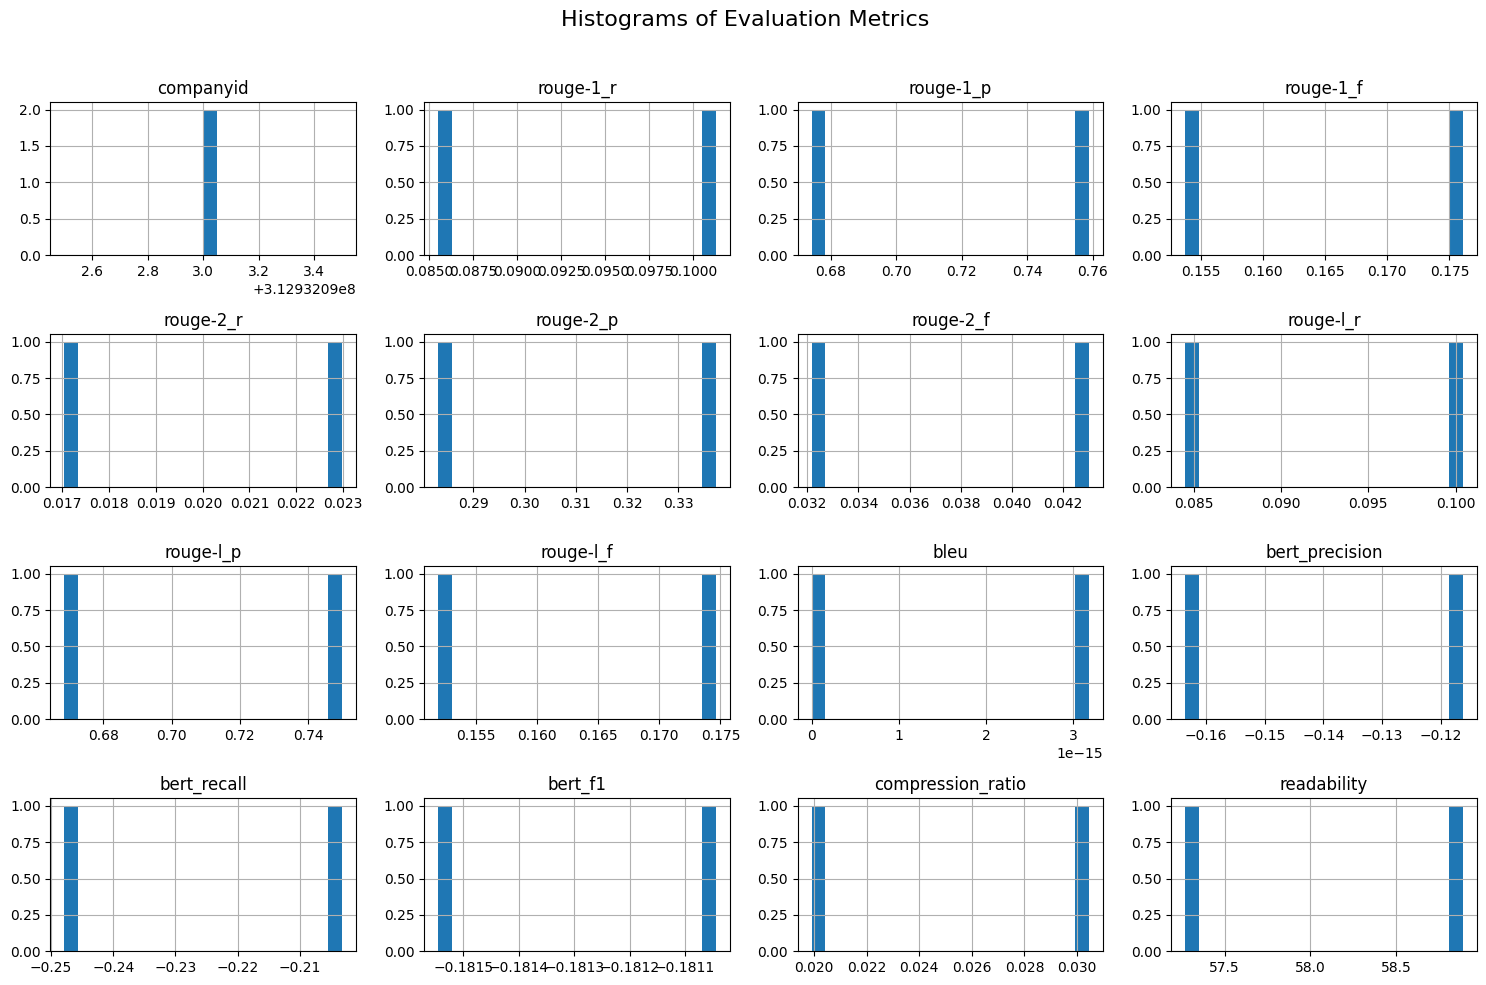

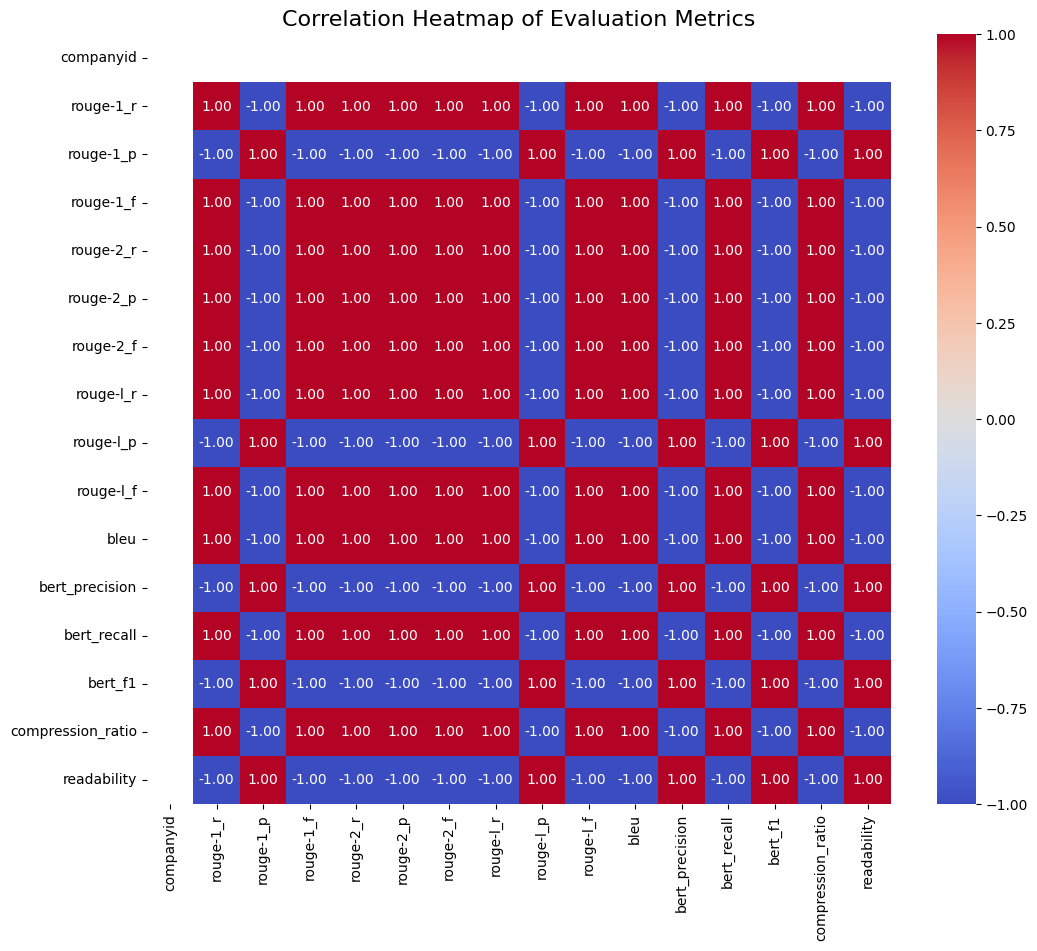

In [ ]:
def visualize_results(df):
    '''
    Visualizes evaluation metrics stored in a DataFrame.
    
    Parameters:
    df (pandas.DataFrame): DataFrame containing evaluation results with numeric metric columns.
    
    This function produces:
    - Histograms for each numeric metric.
    - A correlation heatmap of the numeric metrics.
    '''
    numeric_cols = df.select_dtypes(include='number').columns.tolist()
    
    df[numeric_cols].hist(bins=20, figsize=(15, 10))
    plt.suptitle('Histograms of Evaluation Metrics', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
    
    plt.figure(figsize=(12, 10))
    correlation_matrix = df[numeric_cols].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Heatmap of Evaluation Metrics', fontsize=16)
    plt.show()

visualize_results(evaluation_results)

In [ ]:
df.to_csv(
        Path('..') / 'data' / 'summaries' / f'{company_id}_{model_name}.csv'.replace('/','-'),
        sep='\t',
        index=False,
        quoting=1,
        escapechar='\\',
        doublequote=True,
        quotechar='"',
        lineterminator='\n'
    )

In [ ]:
df.full_text[0]

'Attendees: Now if there\'s a company that understands these changes, including machine learning and big data, as well as open source and collaboration, it\'s Google. You saw one of Google\'s open source projects, TensorFlow, in today\'s demo. Just a few minutes, Google Chief Decision Scientist will be here. But before she gives you more information about what intelligent apps will really look like, we\'ll hear from a shared customer, Kohl\'s, about their journey with Red Hat and Google. So please welcome Ritch from Kohl\'s and Cassie from Google.\nAttendees: All right. Most of you know Kohl\'s as a chain of leading American department stores, but you might not know that there\'s also been a long-time customer of Red Hat. Ritch, could you tell a little bit about Kohl\'s and your relationship with us?\nAttendees: Sure thing. So first of all, it\'s great to be here. I was really looking forward to summit this year, and then I saw Weezer was playing, and that put me right over the top, ic

In [ ]:
df[summary_column][0]

"CEO from Kohl's says the company is excited to work with Red Hat. Machine learning is an approach to making lots of small Scientists at Massachusetts Institute of Technology have developed a machine that can identify cats. Machine learning is at the heart of everything we do. Machine learning takes over the cooking part of the kitchen. Machine learning and big data are changing the way we work. Google has announced partnerships with Canonical and Red Hat. Machine learning and AI are the new programming paradigm. Cloud AutoML lets you adjust what already exists out there. Machine learning is at the heart of everything we do. Machine learning is changing the way we work. Three different chefs are using Google Cloud to run their businesses Ritch talks about why he chose to work with Red Hat. Machine learning is just a way of doing things. Scientists at Massachusetts Institute of Technology have created a program that can identify cats. Machine learning can be used to solve business probl